# Case study: Aecert Robotics gaits gen

Aecert Robotics youtube channel covers a hexapod build and it mentions a new gait generation algorithm that allows on the fly transitions https://youtu.be/DKsyJYkdZ_o?si=0ym37QSEdOcEfFBf

With some google search it looks like code is here https://github.com/Ryan-Mirch/Aecerts_Hexapod_V1/blob/main/RC_V3/RC%20Code/src/Pages/GaitsPage.cpp

There is no license attached in the repo, which means now work can be reproduced, distributed or any derivative work can be created... according to https://docs.github.com/en/repositories/managing-your-repositorys-settings-and-features/customizing-your-repository/licensing-a-repository code in public repo can be forked and viewed

This notebook is just a case study of the code in original repo and is not a derivative work. All copyright to the code still belongs to 

Initializing...
Loading calibration data...
No calibration data found, using defaults


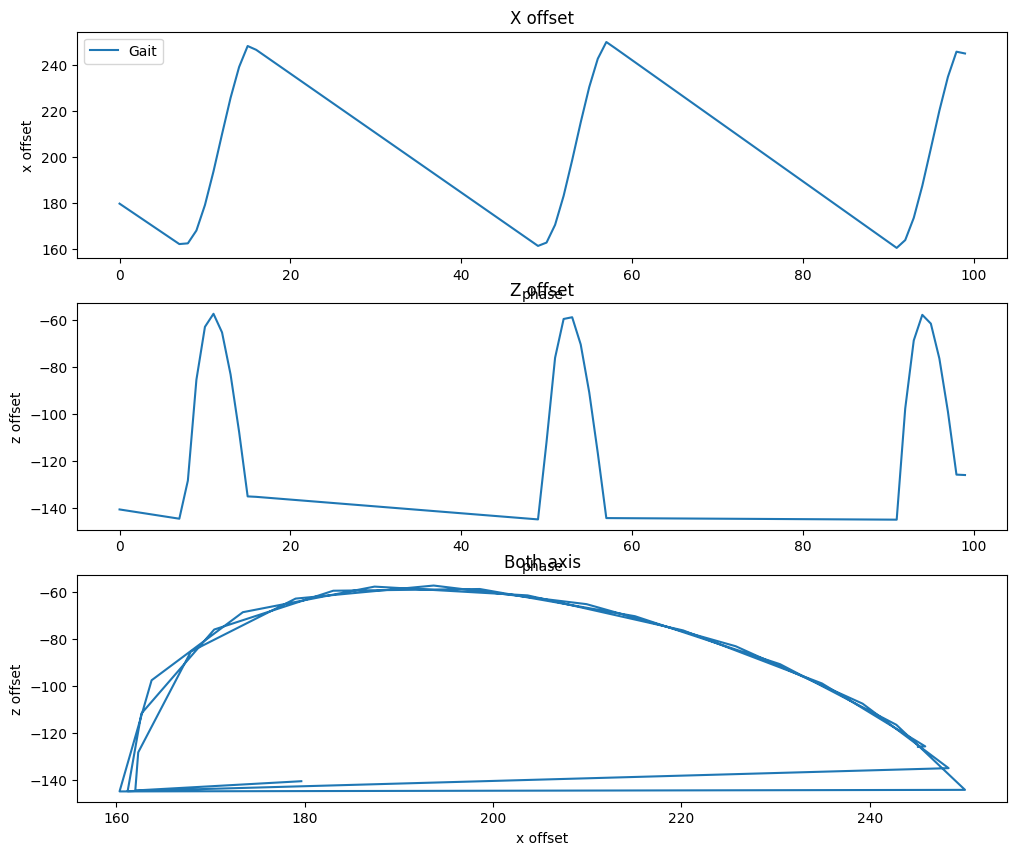

In [17]:
import numpy as np
import matplotlib.pyplot as plt
#!./.venv/bin/python

from matplotlib import pyplot as plt
from globals import PRESSED, Gait, g, PackageType
from hexapod_initializations import setup_sim_legs, a1, a2, a3
from models import HexapodModel

import hexapod_main
from nrf import rc_control_data

rc_control_data.gait = Gait.WAVE
hexapod_main.setup()

g.current_type = PackageType.RC_CONTROL_DATA
hexapod_main.loop()


def process_frame(delta_time=0.001):
    plt.show(block=False)
    plt.pause(delta_time)


g.process_frame = process_frame

hexapod = HexapodModel(
    coxa_len=a1,
    femur_len=a2,
    tibia_len=a3,
    front_offset=85,
    middle_offset=100,
    side_offset=55,
    leg_rotation=[0, 0, g.leg_placement_angle],
)
hexapod.forward_kinematics(0.0, 81.19264931247422, 137.66638455325148)

class MoveRecorder:
    def __init__(self, real_leg):
        self.real_leg = real_leg
        self.leg_positions = []
        self.leg_rotations = []

    def forward_kinematics(self, alpha, beta, gamma):
        self.real_leg.forward_kinematics(alpha, beta, gamma)
        self.leg_rotations.append([alpha, beta, gamma])
        self.leg_positions.append(self.real_leg.tibia_end.numpy())

    def inverse_kinematics_local(self, foot_target):
        return self.real_leg.inverse_kinematics_local(foot_target)

class DummyHexapod:
    def __init__(self):
        self.left_front = MoveRecorder(hexapod.left_front)
        self.left_middle = MoveRecorder(hexapod.left_middle)
        self.left_back = MoveRecorder(hexapod.left_back)
        self.right_front = MoveRecorder(hexapod.right_front)
        self.right_middle = MoveRecorder(hexapod.right_middle)
        self.right_back = MoveRecorder(hexapod.right_back)

        self.all_legs = [
            self.left_front,
            self.left_middle,
            self.left_back,
            self.right_front,
            self.right_middle,
            self.right_back,
        ]

recorder = DummyHexapod()
setup_sim_legs(recorder)

start_frame = 70
end_frame = 170
frame = 0
while frame <= end_frame:
    frame += 1

    if frame >= start_frame:
      g.current_type = PackageType.RC_CONTROL_DATA
      rc_control_data.joy1_Y = 0 # move forward

    hexapod_main.loop()
    # g.process_frame(0.001)


fig, ax = plt.subplots(3, 1)
fig.set_size_inches((12, 10))

phase = np.arange(0, end_frame - start_frame)
gait_points = np.array(recorder.left_front.leg_positions)[start_frame:end_frame]
ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('X offset')
ax[0].plot(phase, gait_points[:, 0], label='Gait')

ax[0].legend()

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')
ax[1].plot(phase, gait_points[:, 2], label='Gait')

# plot both axis
ax[2].set_xlabel('x offset')
ax[2].set_ylabel('z offset')
ax[2].set_title('Both axis')
ax[2].plot(gait_points[:, 0], gait_points[:, 2], label='Gait')

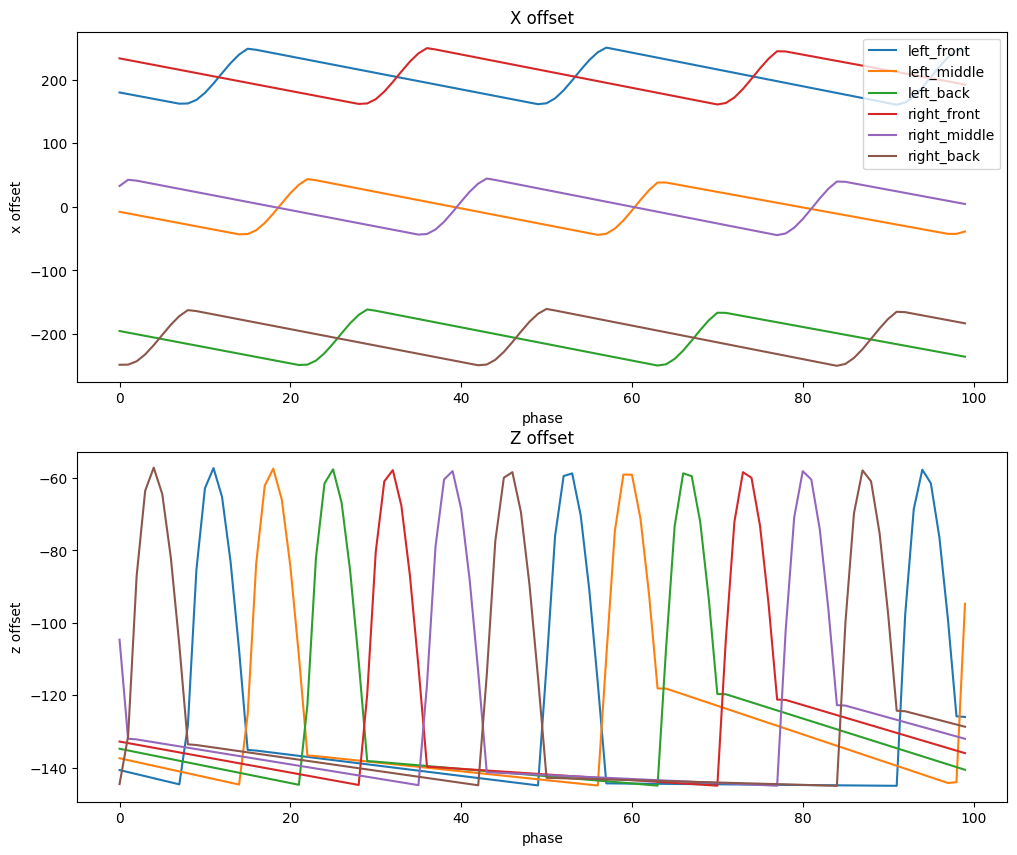

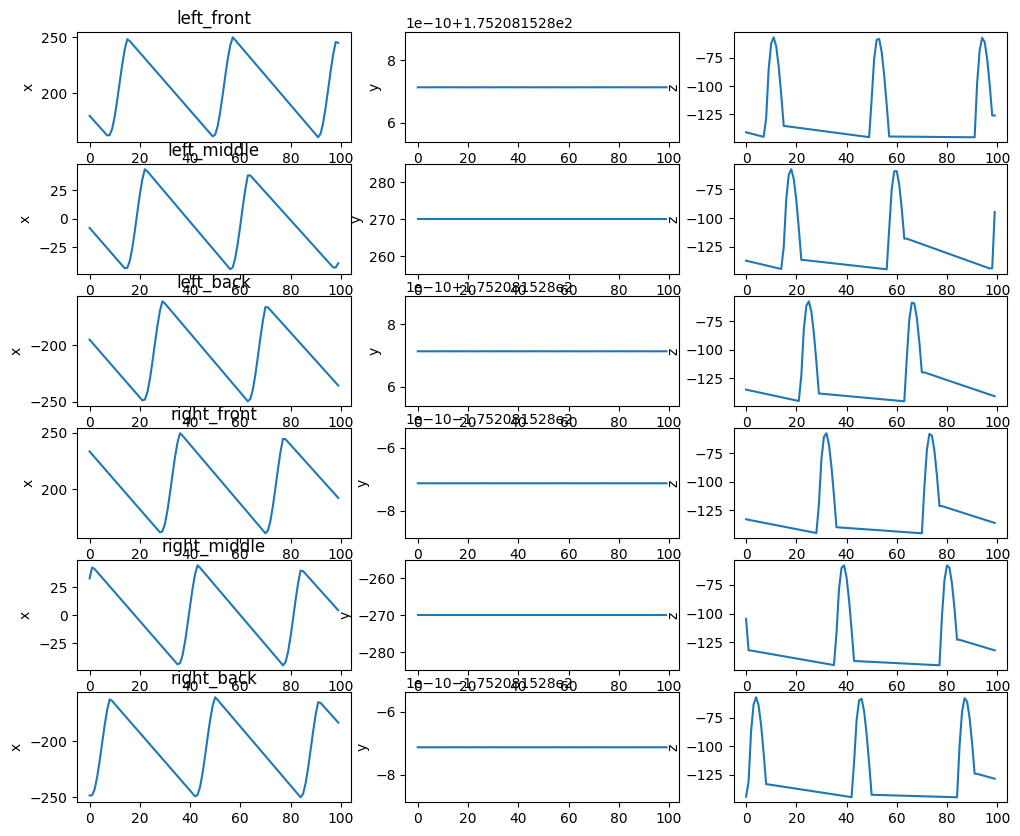

In [20]:
fig, ax = plt.subplots(2, 1)
fig.set_size_inches((12, 10))

phase = np.arange(0, end_frame - start_frame)


for leg in recorder.all_legs:
    gait_points = np.array(leg.leg_positions)[start_frame:end_frame]
    ax[0].plot(phase, gait_points[:, 0], label=leg.real_leg.label)
    ax[1].plot(phase, gait_points[:, 2], label=leg.real_leg.label)

ax[0].set_xlabel('phase')
ax[0].set_ylabel('x offset')
ax[0].set_title('X offset')
ax[0].legend()

ax[1].set_xlabel('phase')
ax[1].set_ylabel('z offset')
ax[1].set_title('Z offset')

fig, ax = plt.subplots(len(recorder.all_legs), 3)
fig.set_size_inches((12, 10))

for i, leg in enumerate(recorder.all_legs):
    ax[i][0].set_title(f'{leg.real_leg.label}')
    ax[i][0].set_ylabel('x')
    ax[i][1].set_ylabel('y')
    ax[i][2].set_ylabel('z')

    gait_points = np.array(leg.leg_positions)[start_frame:end_frame]
    ax[i][0].plot(phase, gait_points[:, 0])
    ax[i][1].plot(phase, gait_points[:, 1])
    ax[i][2].plot(phase, gait_points[:, 2])
